# Lab 2

## Module importing

In [37]:
import os
import re
import string

import pandas as pd
import numpy as np
import nltk

In [74]:
from pathlib import Path
from typing import Dict, List
from itertools import chain
from collections import Counter, OrderedDict

from tqdm import tqdm
from pymystem3 import Mystem
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

## Settings and useful functions

In [40]:
PATH2ROOT = Path('')
PATH2DATA = Path(PATH2ROOT / 'data')

In [41]:
mystem = Mystem() 

In [42]:
N_jokes = 50

## Preparing dataset

In [43]:
with open(PATH2DATA / 'stopwords_ua.txt', 'r') as file:
    stopwords_ua = file.read()
    
with open(PATH2DATA / 'stopwords_ru.txt', 'r') as file:
    stopwords_ru = file.read()

In [44]:
stopwords_ua = stopwords_ua.split('\n')
stopwords_ru = stopwords_ru.split('\n')

stopwords = set(stopwords_ua + stopwords_ru)
len(stopwords)

2414

In [45]:
with open(PATH2DATA / 'medicin.txt', 'r') as file:
    medicin_raw = file.read()
    
with open(PATH2DATA / 'vovochka.txt', 'r') as file:
    vovochka_raw = file.read()

In [46]:
medicin = list(filter(lambda x: x != '', map(lambda x: ' '.join(x.strip().split('\n')[1:]).strip(), medicin_raw.split('\n\n'))))
vovochka = list(filter(lambda x: x != '',map(lambda x: x.strip(), vovochka_raw.split('\n\n'))))

In [49]:
full_dataset = []

index = 1
for i in range(N_jokes):
    full_dataset.append({'№': index, 'text': medicin[i], 'target': 0})
    full_dataset.append({'№': index+1, 'text': vovochka[i], 'target': 1})
    index += 2
full_dataset = pd.DataFrame(full_dataset)
full_dataset.shape

(100, 3)

In [50]:
full_dataset.to_csv(PATH2DATA / 'full_dataset.csv', index=False, encoding='windows-1251')

In [51]:
for limit in [10, 20, 30]:
    full_dataset[:limit*2].to_csv(PATH2DATA / f'train_{limit}.csv', encoding='windows-1251')

In [52]:
full_dataset[60:].to_csv(PATH2DATA / 'test.csv', encoding='windows-1251')

## Simple EDA

In [53]:
def clean_text(text: str) -> List[str]:
    tokens = re.sub(f'[{string.punctuation}]', ' ', text.lower()).split()
    tokens = [mystem.lemmatize(word)[0] for word in tokens if word not in stopwords]
    return tokens

In [54]:
def compute_words_freq(words: str, n_most_common: int = 10) -> OrderedDict:
    words_freq = Counter(words).most_common(n_most_common)
    words_freq = {key: val / len(words) for key, val in words_freq}
    words_freq = OrderedDict(sorted(words_freq.items(), key=lambda t: t[0]))
    
    return words_freq

In [55]:
medicin_all_words = list(chain.from_iterable([re.sub(f'[{string.punctuation}]', ' ', sent.lower()).split() for sent in medicin]))
vovochka_all_words = list(chain.from_iterable([re.sub(f'[{string.punctuation}]', ' ', sent.lower()).split() for sent in vovochka]))

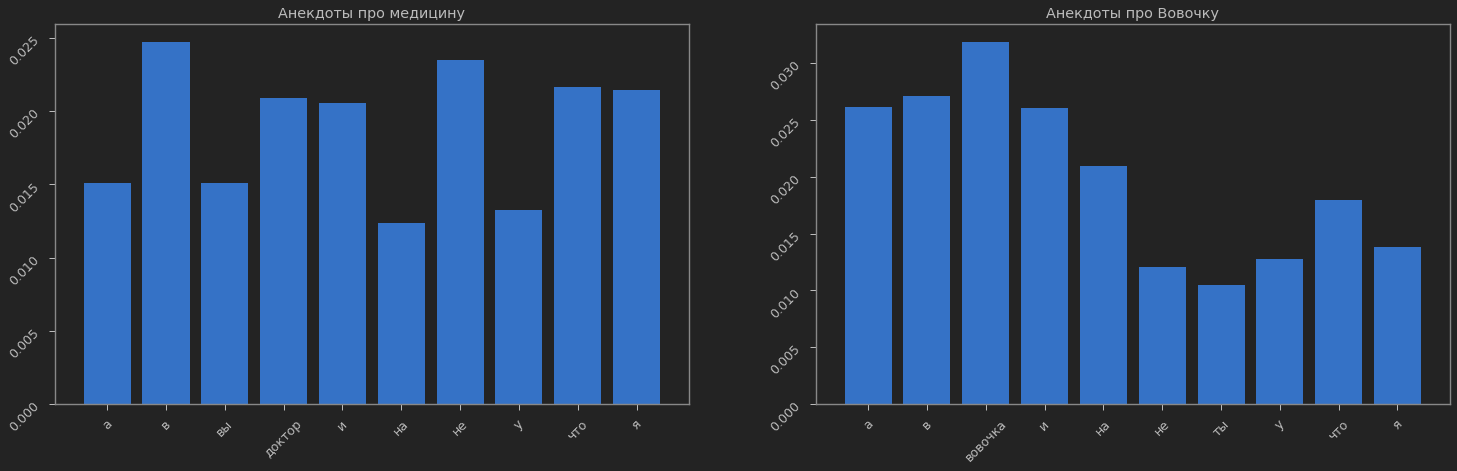

In [56]:
fig, ax = plt.subplots(1,2, figsize=(25,7))

for i, (category, words) in enumerate([('Анекдоты про медицину', medicin_all_words), ('Анекдоты про Вовочку', vovochka_all_words)]):
    od = compute_words_freq(words)
    ax[i].bar(od.keys(), od.values())
    ax[i].title.set_text(category)
    ax[i].tick_params(labelrotation=45)

In [57]:
medicin_all_words = list(chain.from_iterable([clean_text(sent) for sent in medicin]))
vovochka_all_words = list(chain.from_iterable([clean_text(sent) for sent in vovochka]))

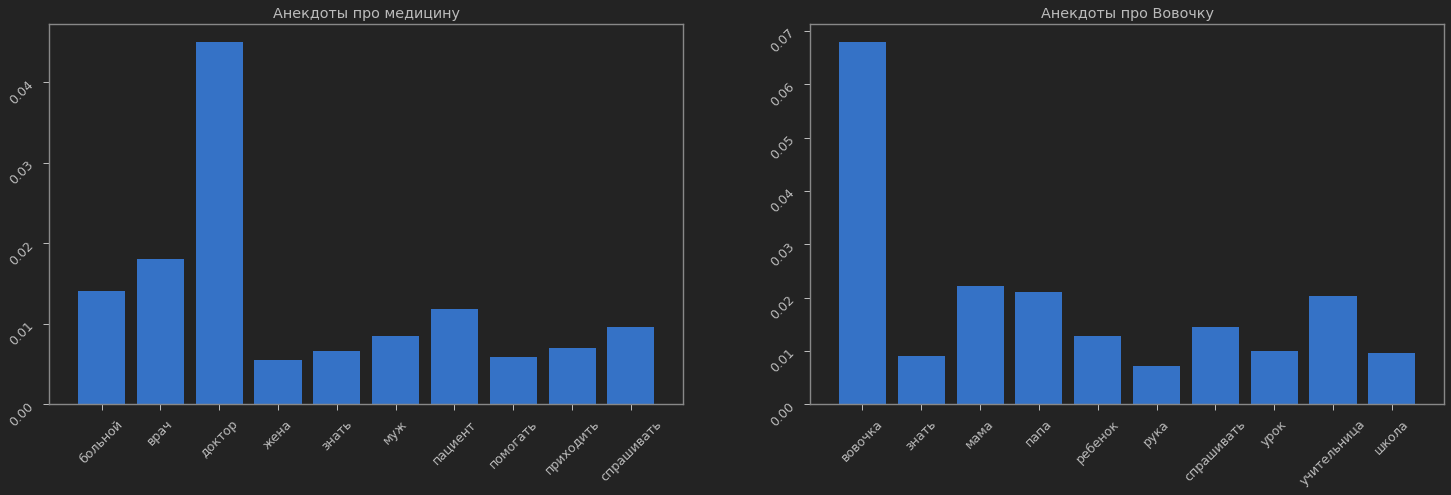

In [58]:
fig, ax = plt.subplots(1,2, figsize=(25,7))

for i, (category, words) in enumerate([('Анекдоты про медицину', medicin_all_words), ('Анекдоты про Вовочку', vovochka_all_words)]):
    od = compute_words_freq(words)
    ax[i].bar(od.keys(), od.values())
    ax[i].title.set_text(category)
    ax[i].tick_params(labelrotation=45)

## Loading train/test samples

In [59]:
train_10 = pd.read_csv(PATH2DATA / f'train_10.csv', encoding='windows-1251')
train_20 = pd.read_csv(PATH2DATA / f'train_20.csv', encoding='windows-1251')
train_30 = pd.read_csv(PATH2DATA / f'train_30.csv', encoding='windows-1251')
test = pd.read_csv(PATH2DATA / f'test.csv', encoding='windows-1251')

## NB model

## Create pipeline and get predictions

In [60]:
simple_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=clean_text)),
    ('classifier', MultinomialNB())
])

In [89]:
results = []
for sample_name, sample in [('train_10', train_10), ('train_20', train_20), ('train_30', train_30)]:
    simple_pipeline.fit(sample.text, sample.target)
    predictions = simple_pipeline.predict_proba(test.text)[:, 1]
    results.append({'sample_name': sample_name,
                    'sample_size': int(sample_name.split('_')[-1]) * 2,
                    'accuracy': accuracy_score(test.target, (predictions > 0.5).astype(int)),
                    'f1_score': f1_score(test.target, (predictions > 0.5).astype(int)),
                    'roc_auc_score': roc_auc_score(test.target, predictions),
                   })
results = pd.DataFrame(results)

In [90]:
results

,sample_name,sample_size,accuracy,precision,recall_score,f1_score,roc_auc_score
0,train_10,20,0.875,0.941176,0.80,0.864865,0.9625
1,train_20,40,0.900,0.863636,0.95,0.904762,0.9750
2,train_30,60,0.950,0.950000,0.95,0.950000,0.9900


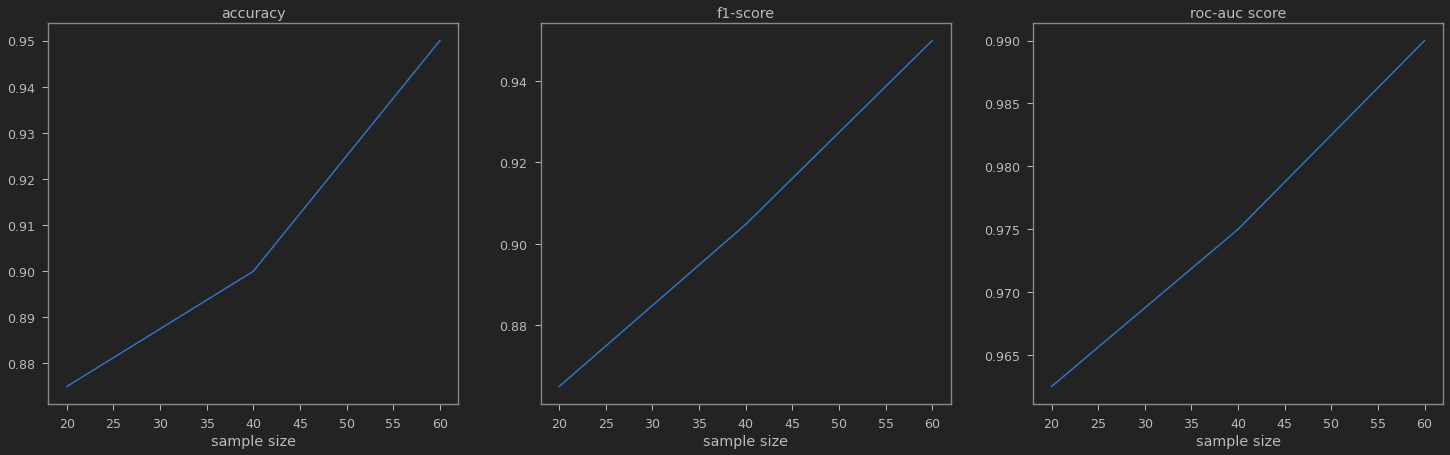

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(25,7))

ax[0].plot(results.sample_size, results.accuracy)
ax[0].title.set_text('accuracy')
ax[0].set_xlabel('sample size');

ax[1].plot(results.sample_size, results.f1_score)
ax[1].title.set_text('f1-score')
ax[1].set_xlabel('sample size');

ax[2].plot(results.sample_size, results.roc_auc_score)
ax[2].title.set_text('roc-auc score')
ax[2].set_xlabel('sample size');